In [35]:
import json
import numpy as np 
import pandas as pd 
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, multilabel_confusion_matrix,make_scorer, balanced_accuracy_score, precision_score, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

# Subtype

In [4]:
def get_pred(proba:np.ndarray): 
    pred = [] 
    for i in range(len(proba)): 
        pred.append(np.argmax(proba[i]).item())
    return pred

In [99]:
result = '/Users/wangheehwan/Desktop/kidney_radiomics/pipeline/result/subtype/0.1PC_xgboost_subtype_9368a2.json'
with open(result) as f:
    file = json.load(f)

### AU-ROC, AU-PRC, F1

In [100]:
#### AU-ROC & F1
# AU-ROC
AUROC = roc_auc_score(file['test_y'], file['mean_pred_proba'], multi_class='ovr', average=None)
# F1 
mean_test_pred = get_pred(file['mean_pred_proba'])
F1 = f1_score(file['test_y'],  mean_test_pred, average=None)
#### AU-PRC
AUPRC = [] 

for i in range(5): 
    test_y_tmp = np.where(np.array(file['test_y']).squeeze() == i, 1, 0)
    AUPRC.append(average_precision_score(test_y_tmp, np.array(file['mean_pred_proba'])[:, i]))

    


print('AU-ROC (one vs rest): {}'.format(AUROC))
print('AU-PRC (one vs rest): {}'.format(AUPRC))
print('F1 (one vs rest): {}'.format(F1))

ValueError: y should be a 1d array, got an array of shape (186, 2) instead.

### specificity, sensitivity, precision, NPV

In [60]:
mean_test_pred = get_pred(file['mean_pred_proba'])
test_cm = multilabel_confusion_matrix(file['test_y'], mean_test_pred)

In [63]:

test_sensitivity = []
test_specificity = []
test_precision  = []
test_npv = []
for i in range(len(test_cm)): 
    tn, fp, fn, tp = test_cm[i].ravel()
    test_sensitivity.append(tp / (tp + fn))
    test_specificity.append(tn / (tn + fp))
    test_precision.append(tp / (tp + fp))
    test_npv.append(tn / (tn + fn))



In [68]:
test_precision

[0.0, 0.34210526315789475, 0.3125, 0.34210526315789475, 0.49851632047477745]

### Confusion Matirx

In [160]:
name = ['Oncocytoma', 'AML', 'chRCC', 'pRCC', 'ccRCC']

train_cm_heatmap = pd.DataFrame(confusion_matrix(file['train_y'], mean_train_pred))
train_cm_heatmap.columns = name 
train_cm_heatmap.index = name 
test_cm_heatmap = pd.DataFrame(confusion_matrix(file['test_y'], mean_test_pred))
test_cm_heatmap.columns = name 
test_cm_heatmap.index = name 



<AxesSubplot: >

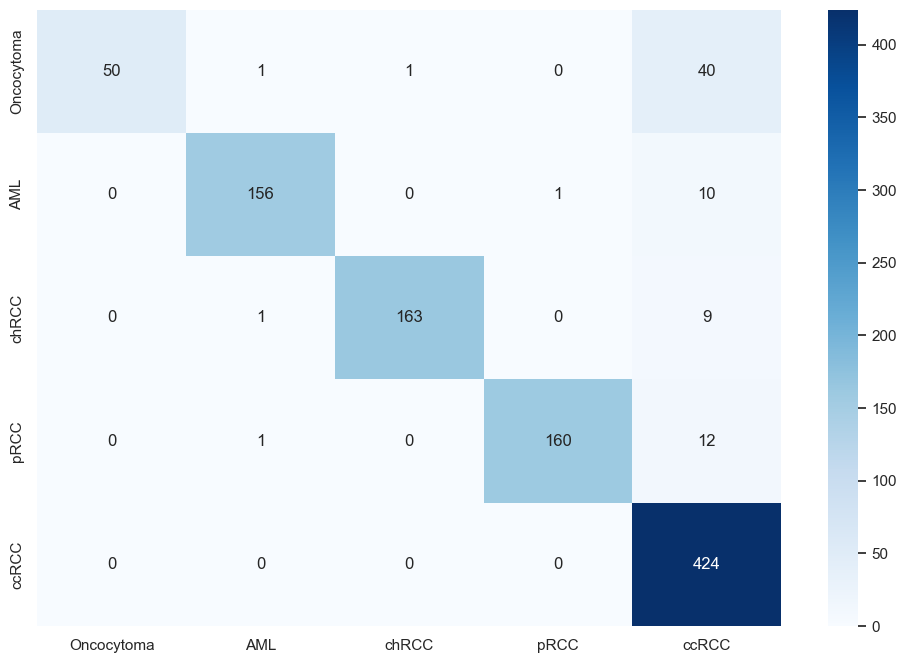

In [161]:
sns.set(rc={'figure.figsize':(12,8)})
sns.heatmap(train_cm_heatmap, cmap="Blues", annot=True, fmt='d')


<AxesSubplot: >

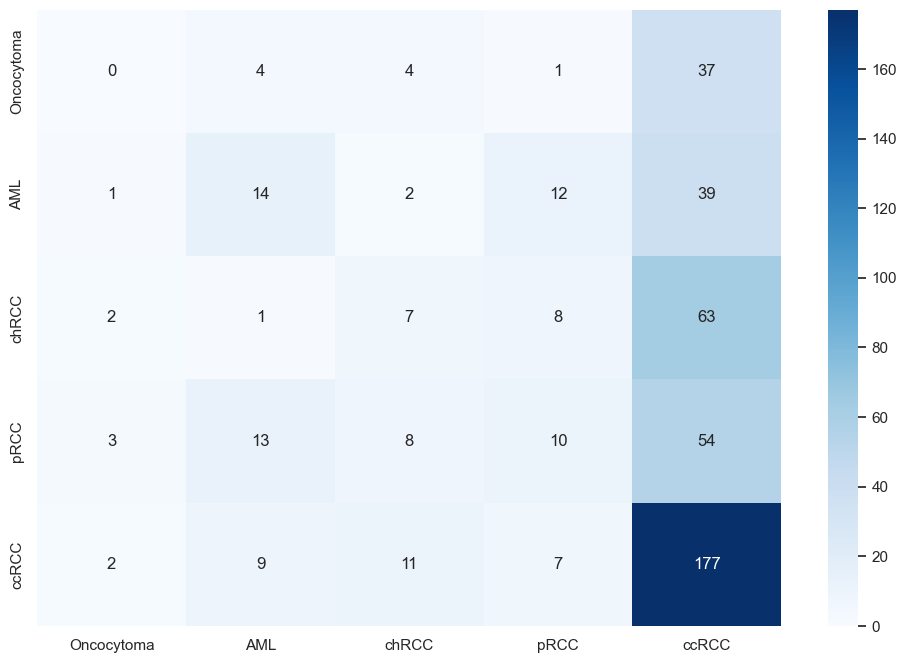

In [162]:
sns.set(rc={'figure.figsize':(12,8)})
sns.heatmap(test_cm_heatmap, cmap="Blues", annot=True, fmt='d')

## Demographic 

### main

In [195]:
import json 
from scipy.stats import ttest_ind, chi2_contingency

with open("/Users/wangheehwan/Desktop/kidney_radiomics/pipeline/subject_list.json", 'rb') as f:
    file = json.load(f)
    train_subject = file['train_subject']
    test_subject = file['test_subject']
    
meta_data = pd.read_csv("/Users/wangheehwan/Desktop/kidney_radiomics/meta_data.csv")
meta_data_train = pd.merge(meta_data, pd.DataFrame({'subjectkey':train_subject}), how='inner', on='subjectkey')
meta_data_test = pd.merge(meta_data, pd.DataFrame({'subjectkey':test_subject}), how='inner', on='subjectkey')
print(len(meta_data_train), len(meta_data_test))
print(len(meta_data_train[meta_data_train['Pathology_binary'] == 0]), len(meta_data_train[meta_data_train['Pathology_binary'] == 1]), len(meta_data_test[meta_data_test['Pathology_binary'] == 0]), len(meta_data_test[meta_data_test['Pathology_binary'] == 1]))

396 103
99 297 27 76


In [197]:
# paired sample t-test for continuous variable
print(ttest_ind(meta_data_train['age'].values, meta_data_test['age'].values))
print(ttest_ind(meta_data_train['size (cm)'].values, meta_data_test['size (cm)'].values))

# chi square test for categorical variable 
# sex
train_male = len(meta_data_train[meta_data_train['sex'] == 1])
train_female = len(meta_data_train[meta_data_train['sex'] == 2])
train_sex = [train_male, train_female]
test_male = len(meta_data_test[meta_data_test['sex'] == 1])
test_female = len(meta_data_test[meta_data_test['sex'] == 2])
test_sex = [test_male, test_female]
df_sex = pd.DataFrame([train_sex, test_sex], columns=['male', 'female'], index=['train', 'test'])
print(chi2_contingency(df_sex))
# malignancy
train_control = len(meta_data_train[meta_data_train['Pathology_binary'] == 0])
train_case = len(meta_data_train[meta_data_train['Pathology_binary'] == 1])
train_patient = [train_control, train_case]
test_control = len(meta_data_test[meta_data_test['Pathology_binary'] == 0])
test_case = len(meta_data_test[meta_data_test['Pathology_binary'] == 1])
test_patient = [test_control, test_case]
df_patient = pd.DataFrame([train_patient, test_patient], columns=['control', 'case'], index=['train', 'test'])
print(chi2_contingency(df_patient))


print("Age (Train): median={}, min={}, max={}. Age (Test): median={}, min={}, max={}".format(np.median(meta_data_train['age'].values), np.min(meta_data_train['age'].values), np.max(meta_data_train['age'].values), np.median(meta_data_test['age'].values), np.min(meta_data_test['age'].values), np.max(meta_data_test['age'].values)))
print("Size (Train): mean={}, min={}, max={}. Size (Test): mean={}, min={}, max={}".format(np.mean(meta_data_train['size (cm)'].values), np.min(meta_data_train['size (cm)'].values), np.max(meta_data_train['size (cm)'].values), np.mean(meta_data_test['size (cm)'].values), np.min(meta_data_test['size (cm)'].values), np.max(meta_data_test['size (cm)'].values)))
print(train_male, train_female, test_male, test_female)


Ttest_indResult(statistic=0.37440797883801635, pvalue=0.7082604985659157)
Ttest_indResult(statistic=1.0514182188215166, pvalue=0.293577495433263)
Chi2ContingencyResult(statistic=0.6735928494725398, pvalue=0.41180177364020853, dof=1, expected_freq=array([[226.17234469, 169.82765531],
       [ 58.82765531,  44.17234469]]))
Chi2ContingencyResult(statistic=0.015688873127846413, pvalue=0.9003214927252494, dof=1, expected_freq=array([[ 99.99198397, 296.00801603],
       [ 26.00801603,  76.99198397]]))
Age (Train): median=57.0, min=22, max=83. Age (Test): median=54.0, min=27, max=79
Size (Train): mean=3.5729797979797984, min=0.7, max=17.5. Size (Test): mean=3.2912621359223295, min=1.0, max=9.4
222 174 63 40


### subtype

In [200]:
import json 
from scipy.stats import ttest_ind, chi2_contingency

with open("/Users/wangheehwan/Desktop/kidney_radiomics/pipeline/subject_list_subtype.json", 'rb') as f:
    file = json.load(f)
    train_subject = file['train_subject']
    test_subject = file['test_subject']
    
meta_data = pd.read_csv("/Users/wangheehwan/Desktop/kidney_radiomics/meta_data.csv")
meta_data['Pathology'] = np.where(meta_data['Pathology'].values == 'Oncocytoma', 0, meta_data['Pathology'].values)
meta_data['Pathology'] = np.where(meta_data['Pathology'].values == 'oncocytoma', 0, meta_data['Pathology'].values)
meta_data['Pathology'] = np.where(meta_data['Pathology'].values == 'AML', 1, meta_data['Pathology'].values)
meta_data['Pathology'] = np.where(meta_data['Pathology'].values == 'chRCC', 2, meta_data['Pathology'].values)
meta_data['Pathology'] = np.where(meta_data['Pathology'].values == 'chromophobe', 2, meta_data['Pathology'].values)
meta_data['Pathology'] = np.where(meta_data['Pathology'].values == 'pRCC', 3, meta_data['Pathology'].values)
meta_data['Pathology'] = np.where(meta_data['Pathology'].values == 'papillary', 3, meta_data['Pathology'].values)
meta_data['Pathology'] = np.where(meta_data['Pathology'].values == 'ccRCC', 4, meta_data['Pathology'].values)
meta_data['Pathology'] = np.where(meta_data['Pathology'].values == 'clear cell ', 4, meta_data['Pathology'].values)

meta_data_train = pd.merge(meta_data, pd.DataFrame({'subjectkey':train_subject}), how='inner', on='subjectkey')
meta_data_test = pd.merge(meta_data, pd.DataFrame({'subjectkey':test_subject}), how='inner', on='subjectkey')
print(len(meta_data_train), len(meta_data_test))
print(len(meta_data_train[meta_data_train['Pathology'] == 0]), len(meta_data_train[meta_data_train['Pathology'] == 1]), len(meta_data_train[meta_data_train['Pathology'] == 2]), len(meta_data_train[meta_data_train['Pathology'] == 3]), len(meta_data_train[meta_data_train['Pathology'] == 4]))
print(len(meta_data_test[meta_data_test['Pathology'] == 0]), len(meta_data_test[meta_data_test['Pathology'] == 1]), len(meta_data_test[meta_data_test['Pathology'] == 2]), len(meta_data_test[meta_data_test['Pathology'] == 3]), len(meta_data_test[meta_data_test['Pathology'] == 4]))

289 210
25 47 48 50 119
23 31 36 39 81


In [201]:
# paired sample t-test for continuous variable
print(ttest_ind(meta_data_train['age'].values, meta_data_test['age'].values))
print(ttest_ind(meta_data_train['size (cm)'].values, meta_data_test['size (cm)'].values))

# chi square test for categorical variable 
# sex
train_male = len(meta_data_train[meta_data_train['sex'] == 1])
train_female = len(meta_data_train[meta_data_train['sex'] == 2])
train_sex = [train_male, train_female]
test_male = len(meta_data_test[meta_data_test['sex'] == 1])
test_female = len(meta_data_test[meta_data_test['sex'] == 2])
test_sex = [test_male, test_female]
df_sex = pd.DataFrame([train_sex, test_sex], columns=['male', 'female'], index=['train', 'test'])
print(chi2_contingency(df_sex))
# malignancy 
train0 = len(meta_data_train[meta_data_train['Pathology'] == 0])
train1 = len(meta_data_train[meta_data_train['Pathology'] == 1])
train2 = len(meta_data_train[meta_data_train['Pathology'] == 2])
train3 = len(meta_data_train[meta_data_train['Pathology'] == 3])
train4 = len(meta_data_train[meta_data_train['Pathology'] == 4])
train_patient = [train0, train1, train2, train3, train4]
test0 = len(meta_data_test[meta_data_test['Pathology'] == 0])
test1 = len(meta_data_test[meta_data_test['Pathology'] == 1])
test2 = len(meta_data_test[meta_data_test['Pathology'] == 2])
test3 = len(meta_data_test[meta_data_test['Pathology'] == 3])
test4 = len(meta_data_test[meta_data_test['Pathology'] == 4])
test_patient = [test0, test1, test2, test3, test4]

df_patient = pd.DataFrame([train_patient, test_patient], columns=['type0', 'type1', 'type2', 'type3', 'type4'], index=['train', 'test'])
print(chi2_contingency(df_patient))

print("Age (Train): median={}, min={}, max={}. Age (Test): median={}, min={}, max={}".format(np.median(meta_data_train['age'].values), np.min(meta_data_train['age'].values), np.max(meta_data_train['age'].values), np.median(meta_data_test['age'].values), np.min(meta_data_test['age'].values), np.max(meta_data_test['age'].values)))
print("Size (Train): mean={}, min={}, max={}. Size (Test): mean={}, min={}, max={}".format(np.mean(meta_data_train['size (cm)'].values), np.min(meta_data_train['size (cm)'].values), np.max(meta_data_train['size (cm)'].values), np.mean(meta_data_test['size (cm)'].values), np.min(meta_data_test['size (cm)'].values), np.max(meta_data_test['size (cm)'].values)))
print(train_male, train_female, test_male, test_female)



Ttest_indResult(statistic=-0.23329202451958372, pvalue=0.8156307034315694)
Ttest_indResult(statistic=1.2400528397193302, pvalue=0.21554099230987864)
Chi2ContingencyResult(statistic=0.22001211318511651, pvalue=0.6390306888880636, dof=1, expected_freq=array([[165.06012024, 123.93987976],
       [119.93987976,  90.06012024]]))
Chi2ContingencyResult(statistic=1.1818283951081066, pvalue=0.881081296712111, dof=4, expected_freq=array([[ 27.7995992 ,  45.1743487 ,  48.6492986 ,  51.54509018,
        115.83166333],
       [ 20.2004008 ,  32.8256513 ,  35.3507014 ,  37.45490982,
         84.16833667]]))
Age (Train): median=57.0, min=22, max=83. Age (Test): median=57.0, min=27, max=81
Size (Train): mean=3.629411764705883, min=0.8, max=17.5. Size (Test): mean=3.357142857142857, min=0.7, max=12.0
162 127 123 87


In [199]:
df_patient

,type0,type1,type2,type3,type4
train,0,0,0,0,0
test,0,0,0,0,0


In [193]:
123 / (123 + 87)

0.5857142857142857

In [179]:
210 / (289 + 210)

0.42084168336673344